In [187]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats.distributions import chi2
import scipy

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [4]:
# df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")
df1 = pd.read_csv("~/selCoefEst/traindata/trip-2021-10-20.csv")

In [5]:
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [23]:
## read-in saved model (no retraining required)
prob_model = tf.keras.models.load_model('saved_model/lognorm_model', compile=False)
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))
# compile the loaded model with the custome objects
prob_model.compile(optimizer='adam', loss=negloglik)

2021-10-21 22:24:13.815944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-21 22:24:14.209659: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [6]:
dat

array([[ 2.000000e-04, -1.000000e+02,  1.000000e+00,  7.789654e+00,
         0.000000e+00],
       [ 2.100000e-03, -1.000000e+02,  1.800000e+01,  4.680363e+01,
         7.000000e+00],
       [ 4.300000e-03, -1.000000e+02,  9.000000e+00,  7.339328e+01,
         5.900000e+01],
       ...,
       [ 4.070000e-01, -1.000000e-02,  6.053000e+03,  6.168793e+03,
         4.320000e+03],
       [ 1.000000e-03, -1.000000e-02,  4.000000e+00,  6.814663e+01,
         2.000000e+00],
       [ 3.600000e-03, -1.000000e-02,  1.070000e+02,  2.022972e+02,
         1.570000e+02]])

In [24]:
## picking a choice of g1 and g2 & creating a new data frame
trueg1 = -10.0
trueg2 = -1.0
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
newdat = newdf1.to_numpy()

In [86]:
# log P(Xl | gamma)
def get_lp_xl(g, Xlred, N=2500):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(len(Xlred))
    ub = np.exp(2.*g)*scipy.special.expi(-2.*g*0.25/N) - scipy.special.expi(2.*g*(1-0.25/N)) - np.exp(2.*g)*(np.log(0.25/N) - np.log(1-0.25/N))
    #scipy.special.expi(-g*0.25/N) - np.exp(-g)*scipy.special.expi(g*(1-0.25/N)) - np.log(0.25/N) + np.log(1-0.25/N)
    lb = np.exp(2.*g)*scipy.special.expi(2.*g*(0.25/N-1)) - scipy.special.expi(2.*g*0.25/N) - np.exp(2.*g)*(np.log(1-0.25/N) - np.log(0.25/N))
    #scipy.special.expi(g*(0.25/N-1)) - np.exp(-g)*scipy.special.expi(g*0.25/N) - np.log(1-0.25/N) + np.log(0.25/N)
    scalfact = (ub - lb)/(np.expm1(2.*g))
    # return a vector...
    for ix, x in enumerate(Xlred):
        res[ix] = np.exp(2.*g)*scipy.special.expi(2.*g*(x-1)) - scipy.special.expi(2.*g*x) - np.exp(2.*g)*(np.log(1-x) - np.log(x))
        #-np.log(x) - np.log(1.-x) + np.log((1.-np.exp(-2.*g*(1.-x)))/(1.-np.exp(-2.*g))) / scalfact
    #res = np.sum(-np.log(xl) - np.log(1.-xl) + np.log((1.-np.exp(-2.*g*(1.-xl)))/(1.-np.exp(-2.*g)))) / scalfact
    return res/scalfact

In [88]:
np.sum(np.log(0.5*np.exp(get_lp_xl(-0.1,dat[:,0])+0.5*np.exp(get_lp_xl(-1.,dat[:,0])))))

7678.774340920625

In [170]:
# log P(Xl, al | gamma)
def get_lp_alxl(g, Xlred, logalred, prob_model=prob_model):
    """function to compute L(gamma|Xl,al), where gamma is a range of values and Xl & al are given sets of freqs and ages"""

    res = np.empty(len(logalred))

    ahat = prob_model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
    preds = ahat.mean().numpy()
    preds_sd = ahat.stddev().numpy()

    for ia, a in enumerate(logalred):
        res[ia] = scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia]) 
    return res

(array([1.856e+03, 6.400e+01, 2.700e+01, 2.600e+01, 1.100e+01, 9.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00]),
 array([1.0000e+00, 2.3730e+03, 4.7450e+03, 7.1170e+03, 9.4890e+03,
        1.1861e+04, 1.4233e+04, 1.6605e+04, 1.8977e+04, 2.1349e+04,
        2.3721e+04]),
 <BarContainer object of 10 artists>)

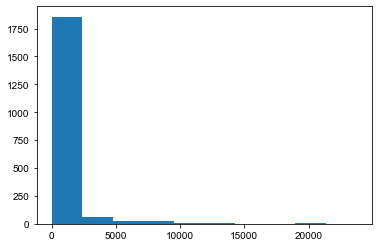

In [120]:
plt.hist(newdat[:,2])

CPU times: user 5.79 s, sys: 52.3 ms, total: 5.84 s
Wall time: 6.72 s


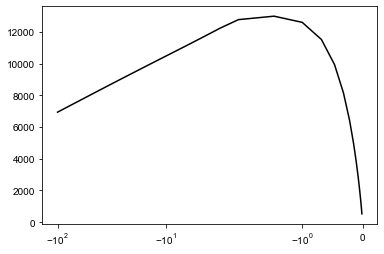

In [196]:
%%time
## assuming only one selection coefficient and only freq info
sin_onlyfreq = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(g, dat[:,0]))
plt.plot(gamma,sin_onlyfreq,'k')
plt.xscale('symlog')

In [197]:
%%time
## assuming two selection coefficients and only freq info (split 50/50)
dub_onlyfreq = np.empty((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma):
        dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, dat[:,0])) + 0.5*np.exp(get_lp_xl(g2, dat[:,0]))))

CPU times: user 4min 47s, sys: 551 ms, total: 4min 48s
Wall time: 4min 56s


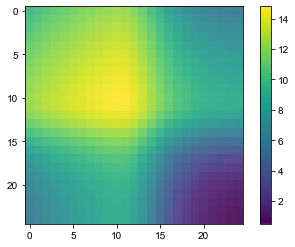

In [195]:
plt.imshow(dub_onlyfreq,alpha=0.9,interpolation='none')
plt.colorbar()

In [119]:
gamma[np.linspace(0,24,6,dtype='int')]

array([-1.000000e+02, -2.154435e+01, -3.162278e+00, -4.641589e-01,
       -6.812921e-02, -1.000000e-02])

In [124]:
get_lp_alxl(-10., dat[:,0], np.log(dat[:,2]))

array([ 4.10198806, -1.3166505 , -1.64304214, ..., -1.21626752,
       -1.48278945, -1.70253208])

In [125]:
%%time
## assuming only one selection coefficient and both age & freq info
sin_agefreq = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    sin_agefreq[ig] = np.sum(get_lp_alxl(g, dat[:,0], np.log(dat[:,2])) + get_lp_xl(g, dat[:,0]))

plt.plot(gamma,sin_agefreq,'k')
plt.xscale('symlog')
plt.yscale('symlog')

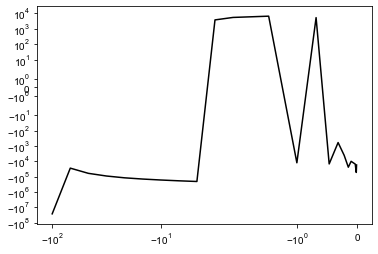

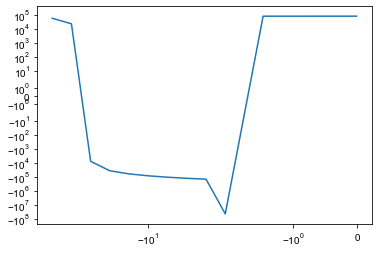

In [129]:
# using only the allele age and freq (not adding component from freq...)
plt.plot(gamma,[np.sum(get_lp_alxl(g, dat[:,0], np.log(dat[:,2]))) for g in gamma])
plt.xscale('symlog')
plt.yscale('symlog')

In [175]:
%%time
## assuming two selection coefficients and only freq info (split 50/50)
dub_agefreq = np.empty((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma):
        dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, dat[:,0], np.log(dat[:,2])) + get_lp_xl(g1, dat[:,0])) + 
        0.5*np.exp(get_lp_alxl(g2, dat[:,0], np.log(dat[:,2])) + get_lp_xl(g2, dat[:,0]))))

CPU times: user 6.59 s, sys: 43.8 ms, total: 6.64 s
Wall time: 7.17 s


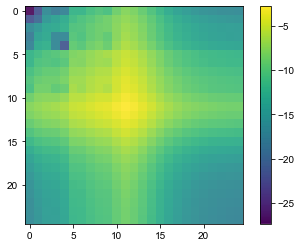

In [176]:
plt.imshow(dub_agefreq,alpha=0.9,interpolation='none')
plt.colorbar()

In [177]:
## get MLE from calculated matrices/vectors
estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

estgagefreq = gamma[np.argmax(sin_agefreq)]

estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]

estg1agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[0]]
estg2agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[1]]

In [192]:
## get likelihood ratio value
lambfreq = -2.*(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq] - sin_onlyfreq[gamma==estgonlyfreq])
print(chi2.sf(lambfreq, 1))

lambagefreq = -2.*(dub_agefreq[gamma==estg1agefreq,gamma==estg2agefreq] - sin_agefreq[gamma==estgagefreq])
print(chi2.sf(lambagefreq, 1))

[0.]
[0.]


In [193]:
lambagefreq

array([13372.30229036])